In [1]:
import pickle
import numpy as np
import fish_3d as f3
import fish_track as ft
import fish_corr as fc
import matplotlib.pyplot as plt
from scipy import ndimage
from scipy.optimize import fsolve
import itertools
import ipyvolume as ipv
import cv2
from PIL import Image

%load_ext autoreload
%autoreload 2

# Undistort the Image firstly

In [5]:
if False:
    distorted = list(ft.read.iter_image_sequence('.', 'cam-'))
    cameras = []
    for i in range(1, 4):
        with open(f'camera_{i}.pkl', 'rb') as f:
            cameras.append(pickle.load(f))

    for i, (im, cam) in enumerate(zip(distorted, cameras)):
        img = cv2.undistort(im.astype(float), cam.k, cam.distortion)
        img = Image.fromarray(img.astype(np.uint8))
        img.save(f'./undist-cam-{i+1}.png')

# Get the Origin

In [7]:
with open('vanilla_trajectories.pkl', 'rb') as f:
    trajectories = pickle.load(f)
cameras = []
for i in range(1, 4):
    with open(f'camera_{i}.pkl', 'rb') as f:
        cameras.append(pickle.load(f))

ints = []

for cam in cameras:
    cam.update()
    ints.append(cam.k)
        
origins_mv = np.array([[982, 752], [991, 827], [1073, 787]])  # measured manually from FIJI
origin, err = f3.ray_trace.ray_trace_refractive_faster(origins_mv, cameras)
print(origin)

[-238.77590004  170.7694139  -329.29509689]


# Get the Surface


An ellipse centred at $\bf{0}$ without rotation is

$$
\frac{x^2}{a^2} + \frac{y^2}{b^2} = 1
$$

The standard parametric ellipse is

$$
\begin{aligned}
(x, y) &= (a\ \cos t, b \ \sin t) & (t \in [0, 2\pi])
\end{aligned}
$$

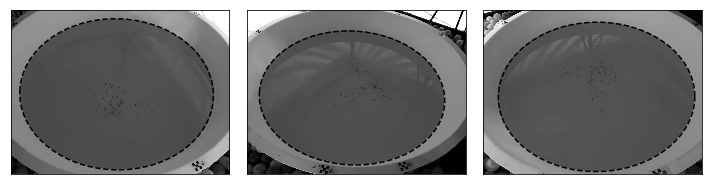

In [14]:
imgs = list(ft.read.iter_image_sequence('.', 'undist-cam-'))

surface_mv = np.empty((3, 100, 2))  # view_num, point_num, dimension
a = np.linspace(0, np.pi * 2, 100)
fig, ax = plt.subplots(1, 3)
ellipses_water = f3.ellipse.parse_ellipses_imagej('./ellipses_water.csv')

for i in range(3):
    img = imgs[i].copy()
    ellipse_fit = f3.ellipse.draw_ellipse(a, ellipses_water[i])
    surface_mv[i] = ellipse_fit.T
    ax[i].imshow(img)
    ax[i].plot(*ellipse_fit, '--', c='k')
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    
plt.gcf().set_size_inches(10, 5)
plt.tight_layout()
plt.show()


# Calculate the 2D correspondances of points on the ellipse 

Some notes for convenient

$$
\begin{aligned}
\alpha &= a^2 \sin ^2(\theta )+b^2 \cos ^2(\theta ) \\
\beta &= 2 \left(a^2-b^2\right) \sin (\theta ) \cos (\theta )\\
\gamma &= a^2 \cos ^2(\theta )+b^2 \sin ^2(\theta )\\
\delta &= -2 \left(d \left(a^2-b^2\right) \sin (\theta ) \cos (\theta )+a^2 c \sin ^2(\theta )+b^2 c \cos ^2(\theta )\right)\\
\epsilon &= -2 \left(c \left(a^2-b^2\right) \sin (\theta ) \cos (\theta )+a^2 d \cos ^2(\theta )+b^2 d \sin ^2(\theta )\right)\\
\eta &= \sin ^2(\theta ) \left(a^2 c^2+b^2 d^2\right)+\cos ^2(\theta ) \left(a^2 d^2+b^2 c^2\right)+2 c d \left(a^2-b^2\right) \sin (\theta ) \cos (\theta )-a^2 b^2
\end{aligned}
$$

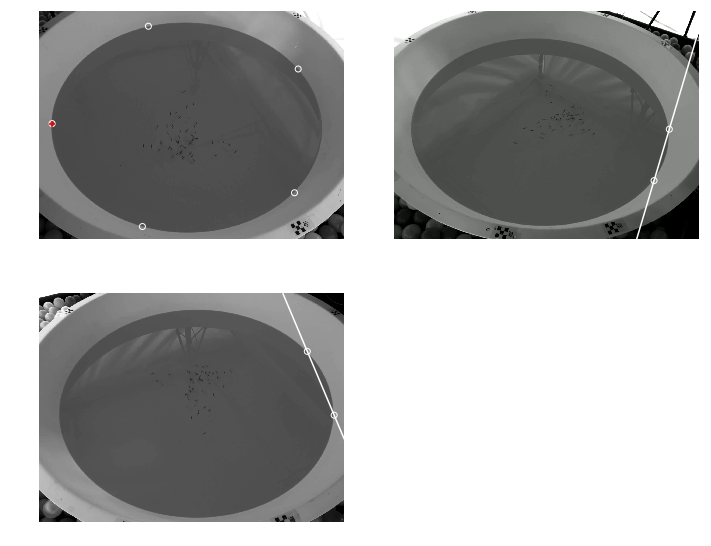

In [9]:
f12 = f3.camera.get_fundamental(cameras[0], cameras[1])
f13 = f3.camera.get_fundamental(cameras[0], cameras[2])

angle_v1 = np.linspace(0, np.pi * 2, 5, endpoint=False)
scatters_v1 = f3.ellipse.draw_ellipse(angle_v1, ellipses_water[0])  # --> xy

p = scatters_v1.T[0]  # xy
ph = np.concatenate((p, [1]))  # uvw, no dist

l12 = f12 @ ph  # uv, no distortion
l13 = f13 @ ph  # uv, no distortion

ep12 = f3.utility.plot_epl(l12, imgs[1])  # uv, no dist
ep13 = f3.utility.plot_epl(l13, imgs[2])  # uv, no dist

cross_12 = f3.ellipse.get_intersection(ellipses_water[1], l12)
cross_13 = f3.ellipse.get_intersection(ellipses_water[2], l13)

plt.subplot(221).scatter(*scatters_v1, color='w', facecolor='none')
plt.gca().imshow(imgs[0])
plt.gca().scatter(*p, color='r', marker='+')
plt.axis('off')

plt.subplot(222).imshow(imgs[1])
plt.gca().plot(*np.flip(ep12, 1), color='w')
plt.gca().scatter(*cross_12, color='w', facecolor='none')
plt.axis('off')

plt.subplot(223).imshow(imgs[2])
plt.gca().plot(*np.flip(ep13, 1), color='w')
plt.gca().scatter(*cross_13, color='w', facecolor='none')
plt.axis('off')

plt.gcf().set_size_inches(10, 8)
plt.tight_layout()
plt.show()

# Results

The results looks very bad. This is probably because I did not consider the distortion properly

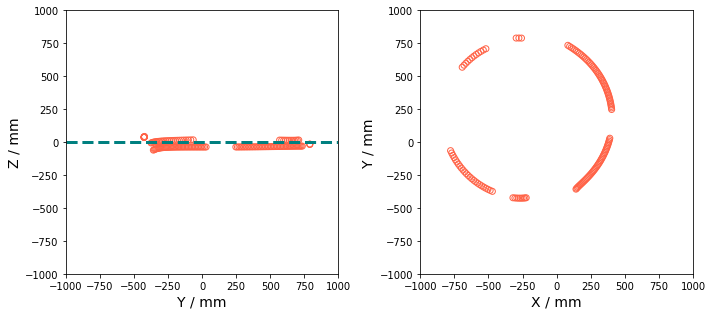

In [50]:
points_water = f3.ellipse.match_ellipse_sloopy(cameras, ellipses_water, N=250, min_diff=300)
plt.subplot(121).scatter(*points_water.T[1:], color='tomato', facecolor='none')
plt.gca().plot([-1000, 1000], [0, 0], color='teal', ls='--', lw=3)
plt.xlim(-1000, 1000)
plt.ylim(-1000, 1000)
plt.xlabel('Y / mm', fontsize=14)
plt.ylabel('Z / mm', fontsize=14)

plt.subplot(122).scatter(*points_water.T[:2], color='tomato', facecolor='none')
plt.xlabel('X / mm', fontsize=14)
plt.ylabel('Y / mm', fontsize=14)
plt.xlim(-1000, 1000)
plt.ylim(-1000, 1000)

plt.gcf().set_size_inches(10, 4.5)
plt.tight_layout()
plt.savefig('water_level_no_dist.png')
plt.show()

np.save('ellipse_3d_water_level', points_water)

# Reconstruct the outer ring

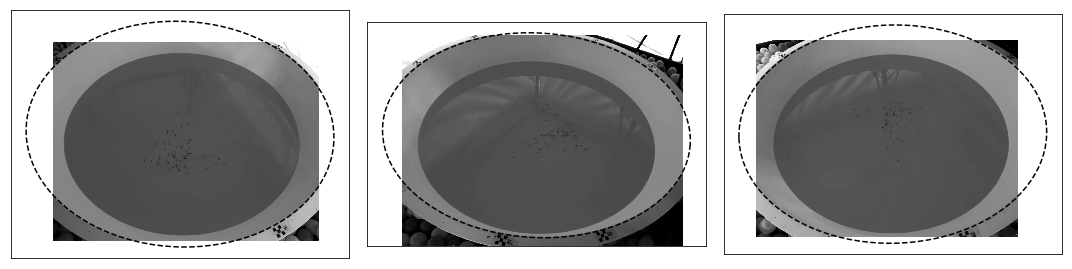

In [21]:
imgs = list(ft.read.iter_image_sequence('.', 'undist-cam-'))

a = np.linspace(0, np.pi * 2, 100, endpoint=True)


fig, ax = plt.subplots(1, 3)
ellipses_tank = []

# fitting point measurements using MatLab code from this paper: 10.1007/s10851-014-0536-x
ellipses_tank.append([
    1190.10154282032, 871.528810566680, 979.370786277759, 712.768135056603, -0.0465865781685177
])

ellipses_tank.append([
    1125.72571098713, 747.069344981404, 979.823180346299, 725.138958439017, -0.0587393927825457
])

ellipses_tank.append([
    1205.76977184994, 854.783454301996, 1071.67431481306, 727.484735075696, -3.11768106348708
])

for i in range(3):
    img = imgs[i].copy()
    ellipse_fit = f3.ellipse.draw_ellipse(a, ellipses_tank[i])
    ax[i].imshow(img)
    ax[i].plot(*ellipse_fit, '--', c='k')
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    
    
plt.gcf().set_size_inches(15, 5)
plt.tight_layout()
plt.show()

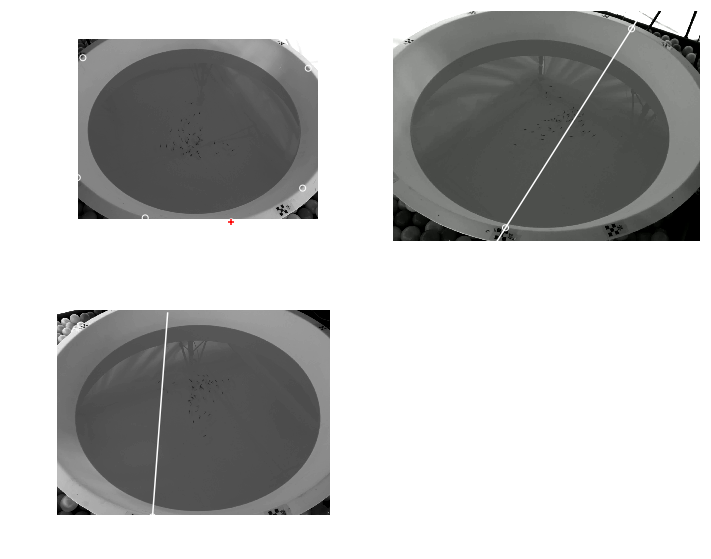

In [23]:
f12 = f3.camera.get_fundamental(cameras[0], cameras[1])
f13 = f3.camera.get_fundamental(cameras[0], cameras[2])

angle_v1 = np.linspace(0, np.pi * 2, 10, endpoint=False)
scatters_v1 = f3.ellipse.draw_ellipse(angle_v1, ellipses_tank[0])  # --> xy

p = scatters_v1.T[2]  # xy
ph = np.concatenate((p, [1]))  # uvw, no dist

l12 = f12 @ ph  # uv, no distortion
l13 = f13 @ ph  # uv, no distortion

ep12 = f3.utility.plot_epl(l12, imgs[1])  # uv, no dist
ep13 = f3.utility.plot_epl(l13, imgs[2])  # uv, no dist

cross_12 = f3.ellipse.get_intersection(ellipses_tank[1], l12)
cross_13 = f3.ellipse.get_intersection(ellipses_tank[2], l13)

plt.subplot(221).scatter(*scatters_v1, color='w', facecolor='none')
plt.gca().imshow(imgs[0])
plt.gca().scatter(*p, color='r', marker='+')
plt.axis('off')

plt.subplot(222).imshow(imgs[1])
plt.gca().plot(*np.flip(ep12, 1), color='w')
plt.gca().scatter(*cross_12, color='w', facecolor='none')
plt.axis('off')

plt.subplot(223).imshow(imgs[2])
plt.gca().plot(*np.flip(ep13, 1), color='w')
plt.gca().scatter(*cross_13, color='w', facecolor='none')
plt.axis('off')

plt.gcf().set_size_inches(10, 8)
plt.tight_layout()
plt.show()

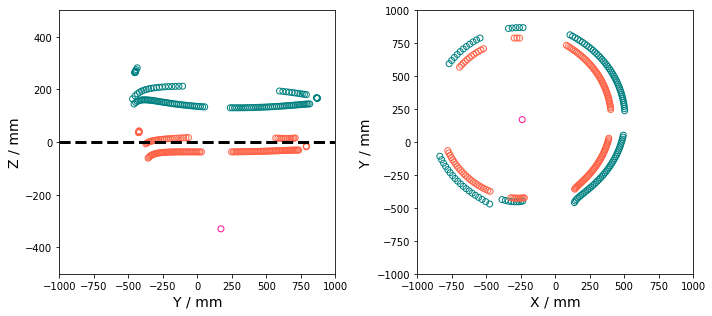

In [51]:
points_tank = f3.ellipse.match_ellipse_sloopy(cameras, ellipses_tank, N=200, min_diff=300)
plt.subplot(121).scatter(*points_tank.T[1:], color='teal', facecolor='none')
plt.gca().scatter(*points_water.T[1:], color='tomato', facecolor='none')
plt.gca().scatter(*origin[1:], color='deeppink', facecolor='none')
plt.gca().plot([-1000, 1000], [0, 0], color='k', ls='--', lw=3)
plt.xlim(-1000, 1000)
plt.ylim(-500, 500)
plt.xlabel('Y / mm', fontsize=14)
plt.ylabel('Z / mm', fontsize=14)

plt.subplot(122).scatter(*points_tank.T[:2], color='teal', facecolor='none')
plt.gca().scatter(*points_water.T[:2], color='tomato', facecolor='none')
plt.gca().scatter(*origin[:2], color='deeppink', facecolor='none')
plt.xlabel('X / mm', fontsize=14)
plt.ylabel('Y / mm', fontsize=14)
plt.xlim(-1000, 1000)
plt.ylim(-1000, 1000)

plt.gcf().set_size_inches(10, 4.5)
plt.tight_layout()
plt.savefig('outer_no_dist.png')
plt.show()

np.save('ellipse_tank', points_tank)

[0.05445571 0.00209409 0.99851399]
1397.2322892600048
1400.5909053471241


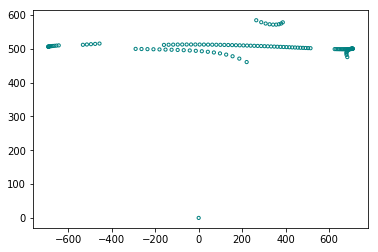

In [52]:
from scipy.spatial.transform import Rotation as R

covar = np.cov(points_water.T)
u, s, vh = np.linalg.svd(covar)
print(vh[-1])


tank = np.vstack((points_tank, origin))
covar = np.cov(tank.T)
u, s, vh = np.linalg.svd(covar)

tank_transformed = vh @ (tank.T - np.vstack(origin))

plt.scatter(*tank_transformed[1:], color='teal', facecolor='none', s=10)

x = tank_transformed[0]
y = tank_transformed[1]

print(x.max() - x.min())
print(y.max() - y.min())

In [53]:
tank = fc.distribution.Tank(origin, points_tank)

In [54]:
with open('tank.pkl', 'wb') as f:
    pickle.dump(tank, f)